## Converting the WSI of Normal lymph node to tiles

In [8]:
import openslide
from openslide import open_slide
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt

In [9]:
slide = open_slide("whole_slide_images/Normal Lymphnode.svs")

In [10]:
slide_props = slide.properties
print(slide_props)

<_PropertyMap {'aperio.AppMag': '40', 'aperio.MPP': '0.241158', 'openslide.comment': 'Aperio Image Library v10.2.24\r\r\n35817x38693 [0,0 35817x38693] [256x256] JPEG/YCbCr Q = 75|AppMag = 40|MPP = 0.241158', 'openslide.level-count': '3', 'openslide.level[0].downsample': '1', 'openslide.level[0].height': '38693', 'openslide.level[0].tile-height': '256', 'openslide.level[0].tile-width': '256', 'openslide.level[0].width': '35817', 'openslide.level[1].downsample': '4.0001075312368233', 'openslide.level[1].height': '9673', 'openslide.level[1].tile-height': '256', 'openslide.level[1].tile-width': '256', 'openslide.level[1].width': '8954', 'openslide.level[2].downsample': '16.003044636184825', 'openslide.level[2].height': '2418', 'openslide.level[2].tile-height': '256', 'openslide.level[2].tile-width': '256', 'openslide.level[2].width': '2238', 'openslide.mpp-x': '0.24115800000000001', 'openslide.mpp-y': '0.24115800000000001', 'openslide.objective-power': '40', 'openslide.quickhash-1': '30d7e

In [11]:
print("Vendor is:", slide_props['openslide.vendor'])

Vendor is: aperio


as it is a svs file so we get the vendor as aperio

In [37]:
print("Pixel size of X in micron is:", slide_props['openslide.mpp-x'])
print("Pixel size of Y in micron is:", slide_props['openslide.mpp-y'])

Pixel size of X in micron is: 0.24115800000000001
Pixel size of Y in micron is: 0.24115800000000001


As it is from optical microscope so it is an isometric pixel(i.e. the x-pixel and y-pixel are of same size)

In [14]:
#Objective used to capture the image

objective = float(slide.properties[openslide.PROPERTY_NAME_OBJECTIVE_POWER])
print("The objective power is: ", objective)


The objective power is:  40.0


This indicated that the slide has been collected at 40X

In [15]:
# get slide dimensions for the level 0 - max resolution level
slide_dims = slide.dimensions
print(slide_dims)

(35817, 38693)


In [40]:
#Get a thumbnail of the image and visualize
slide_thumb_600 = slide.get_thumbnail(size=(600, 600))
slide_thumb_600.show()

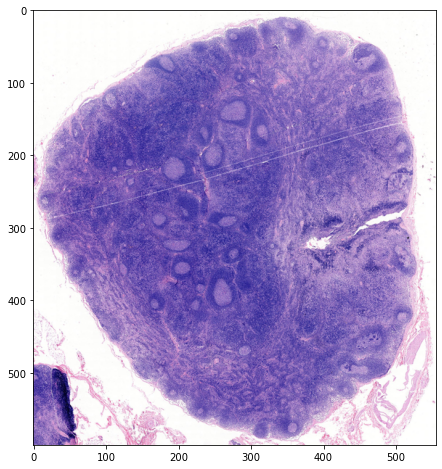

In [17]:
#Convert thumbnail to numpy array
slide_thumb_600_np = np.array(slide_thumb_600)
plt.figure(figsize=(8,8))
plt.imshow(slide_thumb_600_np) 

In [18]:
#Get slide dims at each level. Remember that whole slide images store information
#as pyramid at various levels
dims = slide.level_dimensions

In [19]:
num_levels = len(dims)
print("Number of levels in this image are:", num_levels)

Number of levels in this image are: 3


In [20]:
print("Dimensions of various levels in this image are:", dims)

Dimensions of various levels in this image are: ((35817, 38693), (8954, 9673), (2238, 2418))


In [21]:
#By how much are levels downsampled from the original image?
factors = slide.level_downsamples
print("Each level is downsampled by an amount of: ", factors)

Each level is downsampled by an amount of:  (1.0, 4.000107531236823, 16.003044636184825)


In [22]:
#Copy an image from a level
level3_dim = dims[2]
#Give pixel coordinates (top left pixel in the original large image)
#Also give the level number (for level 3 we are providing a valueof 2)
#Size of your output image
#Remember that the output would be a RGBA image (Not, RGB)
level3_img = slide.read_region((0,0), 2, level3_dim) #Pillow object, mode=RGBA


In [41]:
#Convert the image to RGB
level3_img_RGB = level3_img.convert('RGB')
level3_img_RGB.show()

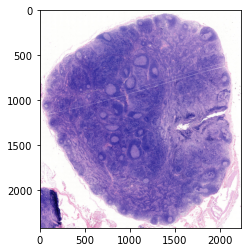

In [24]:
#Convert the image into numpy array for processing
level3_img_np = np.array(level3_img_RGB)
plt.imshow(level3_img_np)


In [25]:
#Return the best level for displaying the given downsample.
SCALE_FACTOR = 32
best_level = slide.get_best_level_for_downsample(SCALE_FACTOR)
#Here it returns the best level to be 2 (third level)
#If you change the scale factor to 2, it will suggest the best level to be 0 (our 1st level)

In [27]:
from openslide.deepzoom import DeepZoomGenerator

In [28]:
#Generate object for tiles using the DeepZoomGenerator
tiles = DeepZoomGenerator(slide, tile_size=256, overlap=0, limit_bounds=False)
#Here, we have divided our svs into tiles of size 256 with no overlap. 

In [29]:
#The tiles object also contains data at many levels. 
#To check the number of levels
print("The number of levels in the tiles object are: ", tiles.level_count)

The number of levels in the tiles object are:  17


In [30]:
print("The dimensions of data in each level are: ", tiles.level_dimensions)

The dimensions of data in each level are:  ((1, 1), (2, 2), (3, 3), (5, 5), (9, 10), (18, 19), (35, 38), (70, 76), (140, 152), (280, 303), (560, 605), (1120, 1210), (2239, 2419), (4478, 4837), (8955, 9674), (17909, 19347), (35817, 38693))


In [31]:
#Total number of tiles in the tiles object
print("Total number of tiles = : ", tiles.tile_count)

Total number of tiles = :  28409


In [54]:
#How many tiles at a specific level?
level_num = 11
print("Tiles shape at level ", level_num, " is: ", tiles.level_tiles[level_num])
print("This means there are ", tiles.level_tiles[level_num][0]*tiles.level_tiles[level_num][1], " total tiles in this level")


Tiles shape at level  11  is:  (5, 5)
This means there are  25  total tiles in this level


In [33]:
#Dimensions of the tile (tile size) for a specific tile from a specific layer
tile_dims = tiles.get_tile_dimensions(11, (3,4)) #Provide deep zoom level and address (column, row)


In [47]:
#Tile count at the highest resolution level (level 16 in our tiles)
tile_count_in_large_image = tiles.level_tiles[16] #126 x 151 (32001/256 = 126 with no overlap pixels
tile_count_in_large_image

(140, 152)

In [49]:
#Check tile size for some random tile
tile_dims = tiles.get_tile_dimensions(16, (120,140))


In [51]:
#Last tiles may not have full 256x256 dimensions as our large image is not exactly divisible by 256
tile_dims = tiles.get_tile_dimensions(16, (139,151))
tile_dims

(233, 37)

In [52]:
single_tile = tiles.get_tile(16, (62, 70)) #Provide deep zoom level and address (column, row)
single_tile_RGB = single_tile.convert('RGB')
single_tile_RGB.show()

In [59]:
###### Saving each tile to local directory
cols, rows = tiles.level_tiles[12]

In [ ]:
import os
tile_dir = "whole_slide_images/Normal Lymphnode tiles/"
for row in range(rows):
    for col in range(cols):
        tile_name = os.path.join(tile_dir, '%d_%d' % (col, row))
        print("Now saving tile with title: ", tile_name)
        temp_tile = tiles.get_tile(12, (col, row))
        temp_tile_RGB = temp_tile.convert('RGB')
        temp_tile_np = np.array(temp_tile_RGB)
        plt.imsave(tile_name + ".png", temp_tile_np)
